In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import sys

In [2]:
sys.path.append('..')
from tlfair.metrics import *
from tlfair.superlearner import *

In [3]:
adult = pd.read_csv(
    "https://raw.githubusercontent.com/socialfoundations/folktables/main/adult_reconstruction.csv"
)
thres = 50000
data = adult.copy()

target = (data["income"] > thres).astype(int)
data = data.drop(columns=['income'])

xtr, xte, ytr, yte = train_test_split(data, target, test_size=0.40, random_state=123)
gtr = (xtr['gender'] == 'Male').astype(np.int8)
gte = (xte['gender'] == 'Male').astype(np.int8)

continuous = ["hours-per-week", "age", "capital-gain", "capital-loss"]
categorical = []
label_encoders = {}

xtr = xtr.drop(columns=['education-num', 'gender'])
xte = xte.drop(columns=['education-num', 'gender'])

for col in xtr.columns:
    if col in continuous:
        continue
    categorical.append(col)
    enc = LabelEncoder()
    label_encoders[col] = enc.fit(xtr[col])
    xtr[col] = enc.transform(xtr[col])
    xte[col] = enc.transform(xte[col])

In [26]:
np.mean(target)

0.23797217903938947

In [25]:
inquire = adult.iloc[np.where(adult['gender']=='Male')]
inquire['income'] = (inquire['income'] > 50000).astype(int)
print('Overall:', np.mean(inquire['income']))
for t in np.unique(inquire['relationship']):
    tmp = inquire.iloc[np.where(inquire['relationship']==t)]
    print(t, ":", np.mean(tmp['income']))

Overall: 0.3019231928618798
Husband : 0.44577352472089316
Not-in-family : 0.12191881918819188
Other-relative : 0.0341047503045067
Own-child : 0.016241299303944315
Unmarried : 0.12239800166527894
Wife : 0.3333333333333333


/tmp/ipykernel_2591044/1486875437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inquire['income'] = (inquire['income'] > 50000).astype(int)


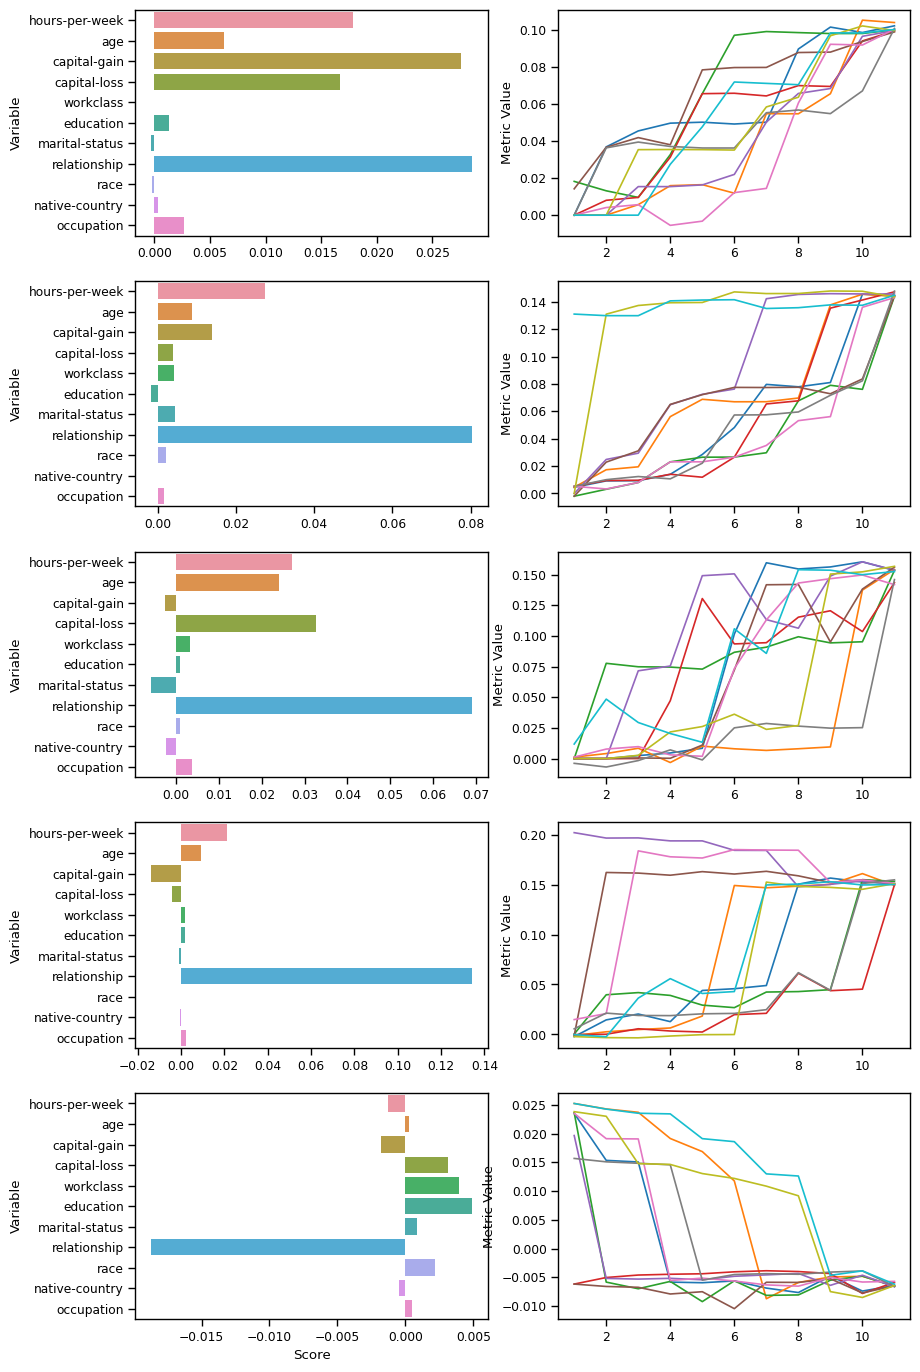

In [14]:
metrics = [
    parity,
    prob_parity,
    opportunity,
    prob_opportunity,
    cmi
]
fig, axs = plt.subplots(5, 2)
fig.set_figwidth(10)
fig.set_figheight(17)
sns.set_context('paper')
for i in range(len(metrics)):
    res = perm_importance(
        xtr = xtr,
        xte = xte,
        ytr = ytr,
        yte = yte,
        gtr = gtr,
        gte = gte,
        outcome = LogisticRegression(solver='liblinear'),
        propensity=LogisticRegression(solver='liblinear'),
        metric = metrics[i]
    )
    importance = res[0]
    importance_df = pd.DataFrame(
        {'Variable': list(importance.keys()),
        'Score': list(importance.values())}
    )
    sns.barplot(importance_df, y='Variable', x='Score', ax=axs[i,0])
    
    values = res[1]
    y = np.arange(1,len(xtr.columns)+1)
    for j in range(len(values)):
        axs[i,1].plot(y,values[j])

    axs[i,1].set_ylabel('Metric Value')
    if i < 4:
        axs[i,0].set_xlabel('')
        axs[i,1].set_xlabel('')

In [15]:
metric_title = [
    'parity',
    'prob_parity',
    'opportunity',
    'prob_opp',
    'cmi'
    ]
for i in range(len(metrics)):
    metric = metrics[i]
    res = res = metric(
        xtr = xtr,
        xte = xte,
        ytr = ytr,
        yte = yte,
        gtr = gtr,
        gte = gte,
        outcome = HistGradientBoostingClassifier(),
        propensity = HistGradientBoostingClassifier(),
    )
    print(metric_title[i])
    print(res[0])
    print(res[1])

parity
0.163311112110701
(0.152674621390938, 0.17394760283046404)
prob_parity
0.178854474456281
(0.16733570492674962, 0.19037324398581237)
opportunity
0.07092171589025337
(-0.1833102696222323, 0.325153701402739)
prob_opp
0.06529560281154104
(0.0020229581184619677, 0.1285682475046201)
cmi
-0.0013100614354323338
(-0.0026834445778157094, 6.332170695104184e-05)


In [4]:
#model = LogisticRegression(solver='liblinear').fit(xtr, ytr)
#model = RandomForestClassifier().fit(xtr, ytr)
#model = KNeighborsClassifier().fit(xtr,ytr)
model = SuperLearnerClassifier().fit(xtr, ytr)
phi0 = -1/np.mean(gte==0) * model.predict(xte.iloc[np.where(gte==0)[0],:])
phi1 = 1/np.mean(gte==1) * model.predict(xte.iloc[np.where(gte==1)[0],:])
phi = np.hstack([phi0, phi1])
est = np.mean(phi)
eif = phi - np.mean(phi)

print(est)
print(est - np.sqrt(np.var(eif)/len(xte)), est + np.sqrt(np.var(eif)/len(xte)))

0.1794225730911324
0.17412697997950563 0.1847181662027592


In [5]:
model.lm.coef_

array([[ 0.81574033,  5.92246961,  0.69009663, -0.02374472, -0.27057919,
         0.27070588]])

In [61]:
propensity = SuperLearnerClassifier().fit(xtr, gtr)
m_probs = propensity.predict_proba(xte)
f_probs = model.predict_proba(xte)[:,1]
phi0 = 1/(np.mean(gte==0)) * (m_probs[:,0]*((yte==1) -f_probs) + (gte==0)*f_probs)
phi1 = 1/(np.mean(gte==1)) * (m_probs[:,1]*((yte==1) -f_probs) + (gte==1)*f_probs)
phi = phi1 - phi0
est = np.mean(phi)
eif = phi - (np.mean(phi1) - np.mean(phi0))

print(est)
print(est - np.sqrt(np.var(eif)/len(xte)), est + np.sqrt(np.var(eif)/len(xte)))

AttributeError: 'SuperLearnerClassifier' object has no attribute 'predict_proba'

In [45]:
xte

,hours-per-week,age,capital-gain,capital-loss,workclass,education,marital-status,relationship,race,native-country,occupation
8877,15,46,0,0,4,11,4,1,2,39,7
32720,50,34,0,0,4,15,2,0,2,39,10
43802,40,57,0,0,1,15,2,0,4,39,4
20666,45,37,0,1740,4,7,2,0,4,39,10
9144,40,26,0,0,0,0,5,2,4,33,0
...,...,...,...,...,...,...,...,...,...,...,...
14477,40,33,0,0,7,15,0,4,2,39,8
33136,30,28,0,0,0,11,5,4,2,39,0
24670,40,45,0,0,1,11,2,0,4,39,1
46183,50,36,0,0,6,4,2,0,4,26,14


In [50]:
label = np.zeros(shape=(len(gtr),)).astype(np.int8)
label[np.intersect1d(np.where(gtr==0), np.where(ytr==0))] = 0
label[np.intersect1d(np.where(gtr==1), np.where(ytr==0))] = 1
label[np.intersect1d(np.where(gtr==0), np.where(ytr==1))] = 2
label[np.intersect1d(np.where(gtr==1), np.where(ytr==1))] = 3
ztr = xtr.copy()[['education', 'hours-per-week', 'occupation']]
model = HistGradientBoostingClassifier().fit(ztr, label)
g_model = HistGradientBoostingClassifier().fit(ztr, gtr)
y_model = HistGradientBoostingClassifier().fit(ztr, ytr)

In [51]:
zte = xte.copy()[['education', 'hours-per-week', 'occupation']]
preds = model.predict_proba(zte)
est = np.zeros(len(gte))
label = np.zeros(shape=(len(gte),)).astype(np.int8)
label[np.intersect1d(np.where(gte==0), np.where(yte==0))] = 0
label[np.intersect1d(np.where(gte==1), np.where(yte==0))] = 1
label[np.intersect1d(np.where(gte==0), np.where(yte==1))] = 2
label[np.intersect1d(np.where(gte==1), np.where(yte==1))] = 3
tol = 1e-2
for i in range(len(preds)):
    numerator = preds[i, label[i]]
    if label[i] == 0:
        denominator = (preds[i,0]+preds[i,2]) * (preds[i,0]+preds[i,1])
    elif label[i] == 1:
        denominator = (preds[i,1]+preds[i,3]) * (preds[i,0]+preds[i,1])
    elif label[i] == 2:
        denominator = (preds[i,0]+preds[i,2]) * (preds[i,2]+preds[i,3])
    elif label[i] == 3:
        denominator = (preds[i,1]+preds[i,3]) * (preds[i,2]+preds[i,3])
    est[i] = np.log((numerator)/(denominator))
print(np.mean(est))
std = np.std(est -np.mean(est))/len(label)
print(np.mean(est)-1.96*std, np.mean(est)+1.96*std)

0.014890836227788924
0.014870660356859081 0.014911012098718767


In [52]:
zte = xte.copy()[['education', 'hours-per-week', 'occupation']]
preds = model.predict_proba(zte)
gpreds = g_model.predict_proba(zte)
ypreds = y_model.predict_proba(zte)
est = np.zeros(len(gte))
label = np.zeros(shape=(len(gte),)).astype(np.int8)
label[np.intersect1d(np.where(gte==0), np.where(yte==0))] = 0
label[np.intersect1d(np.where(gte==1), np.where(yte==0))] = 1
label[np.intersect1d(np.where(gte==0), np.where(yte==1))] = 2
label[np.intersect1d(np.where(gte==1), np.where(yte==1))] = 3
tol = 1e-2

est = np.zeros(len(gte))
for i in range(len(preds)):
    numerator = preds[i, label[i]]
    if label[i] == 0:
        denominator = gpreds[i,0] * ypreds[i,0]
    elif label[i] == 1:
        denominator = gpreds[i,1] * ypreds[i,0]
    elif label[i] == 2:
        denominator = gpreds[i,0] * ypreds[i,1]
    elif label[i] == 3:
        denominator = gpreds[i,1] * ypreds[i,1]
    est[i] = np.log(numerator/denominator)
np.mean(est)

0.014132917435297362

In [35]:
np.std(est-np.mean(est))/np.sqrt(len(gte))

0.0014315278814038622